In [1]:
import sys
import os
from tqdm import tqdm
import random
import numpy as np
import math
# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

sys.path.append(parent_dir)

#import simtrain
from simtrain.sim_models_new import User_simmulation_Model
from simtrain import SETTINGS_POLIMI as SETTINGS
from simtrain import explore_models, process_dat
import simtrain.utils as utils
from simtrain.Dataset import CustomDataset
from simtrain.train import train

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import ast

import paths
from os.path import join
import pytorch_warmup as warmup


In [2]:
#num_items = 7
#num_items_per_recom = 2
num_interaction_types = 2
recom_dim = 1
#num_users = 11
#min_inter = 2
#max_inter = 4
state_size = SETTINGS.STATE_SIZE
subset = 50 # make data smaller
experiment_name = "testing2"

In [12]:
#create dataset from processed data

train_dat, stg = process_dat.load_dat(paths.cw_stages['output_new']['train'], new_data=True)

print(stg)

def convert_string_to_double_list(s):
    return ast.literal_eval(s)

# Apply the custom function
train_dat['item_ids'] = train_dat['item_ids'].apply(convert_string_to_double_list)
train_dat['user_means'] = train_dat['user_means'].apply(convert_string_to_double_list)
train_dat['user_vars_log'] = train_dat['user_vars_log'].apply(convert_string_to_double_list)
train_dat['timestamps'] = train_dat['timestamps'].apply(convert_string_to_double_list)
train_dat['interaction_types'] = train_dat['interaction_types'].apply(convert_string_to_double_list)

print("len: ", len(train_dat))
list_of_dicts = train_dat.to_dict(orient='records')
list_of_dicts = list_of_dicts[:subset]
train_dat.head()

{'NI': 14, 'NU': 328, 'T': '[9.708333333333334, 12.4375, 12.604166666666666, 13.395833333333334, 15.458333333333334, 15.979166666666666, 17.333333333333332, 18.6875, 20.58333333333333, 21.354166666666668, 21.375, 21.39583333333333, 21.416666666666668, 21.4375, 21.45833333333333, 21.479166666666668, 22.52083333333333, 24.39583333333333, 24.416666666666668, 24.4375, 24.45833333333333, 24.479166666666668, 24.5, 24.52083333333333, 25.479166666666668, 25.5, 25.52083333333333, 25.541666666666668, 25.58333333333333, 25.64583333333333, 29.33333333333333, 30.14583333333333, 30.58333333333333, 30.604166666666668, 30.625, 30.979166666666668, 32.0, 34.354166666666664, 36.66666666666666, 36.6875, 37.5625, 37.583333333333336, 38.583333333333336, 43.10416666666666, 43.333333333333336]', 'NS': 100, 'INF_TIME': 1000}
len:  328


,user_id,user_means,user_vars_log,item_ids,timestamps,interaction_types
0,188,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[[119, 74, 263, 144, 261, 53, 217, 194, 178, 2...","[5.416666666666667, 12.25, 13.645833333333334,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,491,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[[144, 279, 79, 84, 74, 247, 162, 165, 161, 13...","[54.35416666666666, 57.270833333333336, 57.354...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ..."
2,561,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[[106, 125, 158, 27, 269, 264, 110, 50, 19, 16...","[20.58333333333333, 26.64583333333333, 28.5625...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,670,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[[165, 157, 187, 155, 95, 202, 99, 237, 288, 5...","[20.33333333333333, 26.39583333333333, 35.3125...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,749,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[[161, 199, 279, 12, 37, 84, 74, 132, 161, 284...","[5.083333333333333, 6.395833333333333, 11.8125...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [4]:

checkpoint = torch.load(join(paths.dat, SETTINGS.rootpaths['models'],
                             experiment_name, "data.h5"))
list_of_dicts = checkpoint['data']

In [5]:
'''
def adjust_hidden_dim(data_dict, state_size):
    # just to jumstart experiments should be deleted at the end
    for row in list_of_dicts:
        if row["user_means"] > state_size:
            row["user_means"] = row["user_means"][:state_size]
            row["user_vars_log"] = row["user_vars_log"][:state_size]
        elif row["user_means"] > state_size:


adjust_hidden_dim(list_of_dicts, state_size)
'''

'\ndef adjust_hidden_dim(data_dict, state_size):\n    # just to jumstart experiments should be deleted at the end\n    for row in list_of_dicts:\n        if row["user_means"] > state_size:\n            row["user_means"] = row["user_means"][:state_size]\n            row["user_vars_log"] = row["user_vars_log"][:state_size]\n        elif row["user_means"] > state_size:\n\n\nadjust_hidden_dim(list_of_dicts, state_size)\n'

In [13]:

dataset = CustomDataset(list_of_dicts) # [:50]
# Example usage with DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)# can only do batchsize 1

In [14]:
def test_timestamps(dataloader):
    smallest = float("inf")
    biggest = -1
    for batch in dataloader:
        timestamps, items, labels, means, var, idx = batch
        last = timestamps[0]
        smallest = min(smallest, last)
        biggest = max(biggest, timestamps[-1])
        for i in range(1,len(timestamps)):
            if timestamps[i] <= last:
                print("error, current: ", timestamps[i], "\tlast", last)
    print(smallest), print(biggest)
    return biggest

max_time = test_timestamps(dataloader)

tensor([0.0417], dtype=torch.float64)
tensor([69.3333], dtype=torch.float64)


In [15]:
for batch in dataloader:
    timestamps, items, labels, means, var, idx = batch
    print('Timestamps:', timestamps#, "\n dtype: ", timestamps.dtype
          )
    print('item_recom:', items#, "\n dtype: ", items.dtype
          )
    print('Labels:', labels#, "\n dtype: ", labels.dtype
          )
    print('means:', means#, "\n dtype: ", means.dtype
          )
    print('log_var:', var#, "\n dtype: ", var.dtype
          )
    break
    

Timestamps: [tensor([5.], dtype=torch.float64), tensor([5.0417], dtype=torch.float64), tensor([5.0833], dtype=torch.float64), tensor([41.0833], dtype=torch.float64)]
item_recom: [[tensor([53]), tensor([50]), tensor([217]), tensor([205]), tensor([66]), tensor([53]), tensor([199]), tensor([134]), tensor([2]), tensor([53]), tensor([66]), tensor([50]), tensor([199]), tensor([77]), tensor([134]), tensor([77]), tensor([2]), tensor([134]), tensor([77]), tensor([50]), tensor([66]), tensor([199]), tensor([217]), tensor([205]), tensor([205]), tensor([217]), tensor([2])], [tensor([168]), tensor([205]), tensor([217]), tensor([138]), tensor([53]), tensor([166]), tensor([203]), tensor([73]), tensor([138]), tensor([168]), tensor([159]), tensor([66]), tensor([268]), tensor([297]), tensor([66]), tensor([261]), tensor([178]), tensor([159]), tensor([178]), tensor([203]), tensor([203]), tensor([159]), tensor([168]), tensor([138]), tensor([217]), tensor([205]), tensor([53]), tensor([57]), tensor([297]), te

In [16]:
# parameter dicts
width= 10
user_state_dict = {"model_hyp": {"layer_width": [width, width, width]}}
intensity_state_dict = {"model_hyp": {"user_model_hyp": {"layer_width": [width, width, 3],
                                                         "noise": 0},
                                          "global_model_hyp": {"layer_width": [width, 3]}}
                            }
interaction_state_dict = {"model_hyp": {"layer_width": [width, width ,width]}
                            }
jump_state_dict = {"model_hyp": {"layer_width": [width, width]}
                        }

In [17]:
import torch.optim as optim

hyperparameter_dict = {"state_size": state_size, "state_model": user_state_dict, "num_interaction_outcomes": num_interaction_types,
                           "intensity_model": intensity_state_dict,# "num_recom" : num_items_per_recom,
                            "recom_dim":recom_dim, "interaction_model": interaction_state_dict,
                            "jump_model": jump_state_dict}
model = User_simmulation_Model(hyperparameter_dict)

In [11]:
# load model
path = join(paths.dat, SETTINGS.rootpaths['models'],
                             experiment_name, "user_model.h5")
model.load_state_dict(torch.load(path))

RuntimeError: Error(s) in loading state_dict for User_simmulation_Model:
	size mismatch for state_model.ode_func.model.0.weight: copying a param with shape torch.Size([10, 8]) from checkpoint, the shape in current model is torch.Size([10, 3]).
	size mismatch for state_model.ode_func.model.6.weight: copying a param with shape torch.Size([8, 10]) from checkpoint, the shape in current model is torch.Size([3, 10]).
	size mismatch for state_model.ode_func.model.6.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([3]).
	size mismatch for intensity_model.user_model.ode.model.0.weight: copying a param with shape torch.Size([10, 8]) from checkpoint, the shape in current model is torch.Size([10, 3]).
	size mismatch for interaction_model.single_interaction_model.model.0.weight: copying a param with shape torch.Size([10, 9]) from checkpoint, the shape in current model is torch.Size([10, 4]).
	size mismatch for jump_model.model.0.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([10, 5]).
	size mismatch for jump_model.model.4.weight: copying a param with shape torch.Size([8, 10]) from checkpoint, the shape in current model is torch.Size([3, 10]).
	size mismatch for jump_model.model.4.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([3]).

In [18]:
num_epochs = 10
warmup_period = len(dataset)
num_steps = num_epochs*len(dataset) -warmup_period
num_iter_til_first_restart = num_steps//2


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

optimizer = optim.AdamW(model.parameters(), lr=0.01,
                        weight_decay=1e-8)
lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=num_iter_til_first_restart, T_mult=1, eta_min=1e-4)

warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)


Using device: cpu


In [19]:
utils.print_user_params(dataloader, print_var = True)

means:  [tensor([0.], dtype=torch.float64), tensor([0.], dtype=torch.float64), tensor([0.], dtype=torch.float64)]
logvar:  [tensor([0.], dtype=torch.float64), tensor([0.], dtype=torch.float64), tensor([0.], dtype=torch.float64)]
means:  [tensor([0.], dtype=torch.float64), tensor([0.], dtype=torch.float64), tensor([0.], dtype=torch.float64)]
logvar:  [tensor([0.], dtype=torch.float64), tensor([0.], dtype=torch.float64), tensor([0.], dtype=torch.float64)]
means:  [tensor([0.], dtype=torch.float64), tensor([0.], dtype=torch.float64), tensor([0.], dtype=torch.float64)]
logvar:  [tensor([0.], dtype=torch.float64), tensor([0.], dtype=torch.float64), tensor([0.], dtype=torch.float64)]
means:  [tensor([0.], dtype=torch.float64), tensor([0.], dtype=torch.float64), tensor([0.], dtype=torch.float64)]
logvar:  [tensor([0.], dtype=torch.float64), tensor([0.], dtype=torch.float64), tensor([0.], dtype=torch.float64)]
means:  [tensor([0.], dtype=torch.float64), tensor([0.], dtype=torch.float64), tenso

In [20]:
train(model, dataloader=dataloader, num_epochs=num_epochs, device=device, loss_func=utils.loss_func, 
                loss_func_kl=utils.kl_loss, kl_weight=1., user_lr=0.1,
                optimizer=optimizer, lr_scheduler=lr_scheduler, num_classes=num_interaction_types, 
                logger=utils.logging_func,warmup_period=warmup_period, intensity_loss_func=utils.square_intensity_loss,
                state_size=state_size,max_time=max_time, log_step_size=1, warmup_scheduler = warmup_scheduler,
                )

  0%|          | 0/10 [00:00<?, ?it/s]/home/thahit/github/Recommender_Sim/simtrain/train.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = nn.functional.log_softmax(y_pred)


In [ ]:
print_user_params(dataloader, print_var = True)

means:  [tensor([0.0149], dtype=torch.float64), tensor([-0.0143], dtype=torch.float64), tensor([0.0468], dtype=torch.float64), tensor([0.0425], dtype=torch.float64), tensor([0.0993], dtype=torch.float64), tensor([0.0387], dtype=torch.float64), tensor([-0.0228], dtype=torch.float64), tensor([-0.0680], dtype=torch.float64)]
logvar:  [tensor([0.1817], dtype=torch.float64), tensor([-0.0555], dtype=torch.float64), tensor([-0.0278], dtype=torch.float64), tensor([-0.3957], dtype=torch.float64), tensor([0.0319], dtype=torch.float64), tensor([-0.1186], dtype=torch.float64), tensor([0.1501], dtype=torch.float64), tensor([0.3147], dtype=torch.float64)]
means:  [tensor([0.0865], dtype=torch.float64), tensor([-0.1777], dtype=torch.float64), tensor([0.0748], dtype=torch.float64), tensor([-0.1917], dtype=torch.float64), tensor([-0.0618], dtype=torch.float64), tensor([0.0318], dtype=torch.float64), tensor([0.0258], dtype=torch.float64), tensor([0.0558], dtype=torch.float64)]
logvar:  [tensor([0.0162],

In [ ]:
SETTINGS.filepaths['user_model']

'saved_models_polimi/accordion/user_model.h5'

In [ ]:
#save model
path = join(paths.dat, SETTINGS.rootpaths['models'],
                             experiment_name, "user_model.h5")

torch.save(model.state_dict(), path)

In [ ]:
# save data(changes during training)
path = join(paths.dat, SETTINGS.rootpaths['models'],
                             experiment_name, "data.h5")
torch.save({
    'data': dataloader.dataset.data,
}, path,
)


total visits for user 6
overall_intensity:  tensor([[0.0069]]) 	user_intensity:  tensor([[0.]]) 	global_intensity:  tensor([0.0069]) 	 before a recommendation.
overall_intensity:  tensor([[0.0069]]) 	user_intensity:  tensor([[0.]]) 	global_intensity:  tensor([0.0069]) 	 before a recommendation.
overall_intensity:  tensor([[0.0069]]) 	user_intensity:  tensor([[0.]]) 	global_intensity:  tensor([0.0069]) 	 before a recommendation.
overall_intensity:  tensor([[0.0069]]) 	user_intensity:  tensor([[0.]]) 	global_intensity:  tensor([0.0069]) 	 before a recommendation.
overall_intensity:  tensor([[0.0069]]) 	user_intensity:  tensor([[0.]]) 	global_intensity:  tensor([0.0069]) 	 before a recommendation.
overall_intensity:  tensor([[0.0069]]) 	user_intensity:  tensor([[0.]]) 	global_intensity:  tensor([0.0069]) 	 before a recommendation.


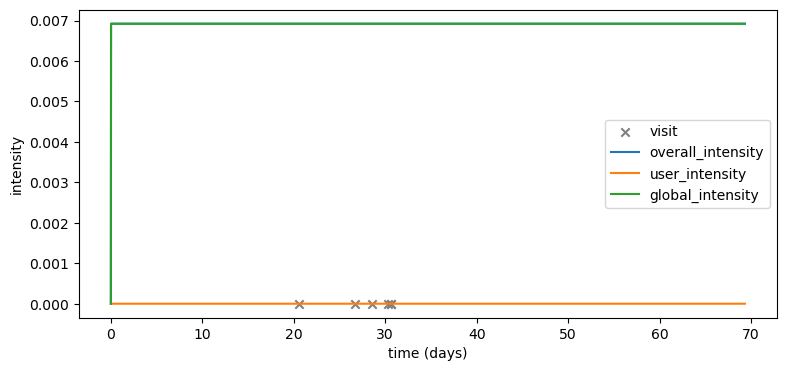

In [ ]:
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2)